In [1]:
%matplotlib inline

import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

#Load data

current_dir = os.path.abspath(".")
data_file_path = os.path.join(current_dir, "..", "data", "sample_data.csv")
data_df = pd.read_csv(data_file_path,index_col=0)
data_df.head()

,A,B,C,E,D,F,G
Date,,,,,,,
1970-01-01,0.034714,0.044682,0.123237,0.017675,0.047517,0.007915,0.226207
1970-02-01,0.024636,0.013480,0.110125,0.015751,0.007594,-0.015778,0.162066
1970-03-01,0.071551,0.023311,0.093957,0.045840,-0.041061,0.009084,0.088476
1970-04-01,-0.006951,0.040709,0.021486,0.038434,0.032244,0.018663,0.072146
1970-05-01,0.010011,0.038496,0.043715,0.024057,-0.017928,0.017422,0.053334


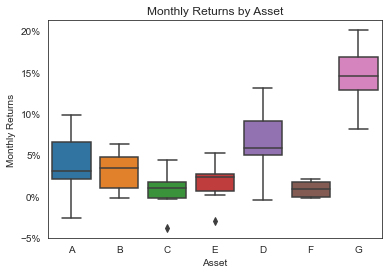

In [4]:
#box and whiskers

def box_plot_monthly_returns(data_df, start_date=None, end_date=None, title=None):
    data_df = data_df.reset_index()
    if start_date and end_date:
        mask = (data_df['Date'] >= start_date) & (data_df['Date'] <= end_date)
        data_df = data_df.loc[mask].reset_index(drop=True)
    
    data_melt_df = pd.melt(data_df, id_vars=['Date'])
    data_melt_df = data_melt_df.rename(columns={'variable': 'Asset', 'value': 'Monthly Returns'})
    
    sns.set_style("white")
    
    ax = sns.boxplot(x='Asset', y='Monthly Returns', data=data_melt_df)
    ax.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1, decimals=0))

    if title:
        ax.set_title(title)

    return plt


chart = box_plot_monthly_returns(data_df, start_date='2022-01-01', end_date='2022-06-30', title="Monthly Returns by Asset")
chart.show()

In [ ]:
def summary_stats_table